In [1]:
# Giovanni: use utils.read_gbq to pull the data, it caches the data
# it takes almost the same input as pandas.read_gbq 
# see the docstrings in utils.py if in doubt
from utils import read_gbq
import matplotlib.pyplot as plt
from tableone import TableOne
from pathlib import Path
import seaborn as sns
import pandas as pd
import numpy as np
import os

In [ ]:
# test different values here 
WINDOW_SIZE=12
OFFSET=6

In [2]:
PROCEDURES=Path("./procedures")
PROJECT_ID=os.getenv('PROJECTID') 

In [148]:
# Transfusiuon Data
transfusion_df=read_gbq(PROCEDURES / "transfusion.sql",project_id=PROJECT_ID)
transfusion_df=transfusion_df.sort_values(by=['patientunitstayid','offset'])
transfusion_df.offset=transfusion_df.offset/60

# HGB Data
hgb_df=read_gbq(PROCEDURES / "hgb.sql",project_id=PROJECT_ID)
hgb_df=hgb_df.sort_values(by=['patientunitstayid','offset'])
hgb_df.offset=hgb_df.offset/60

# Fluids Data
fluids_df=read_gbq(PROCEDURES / "fluid_balance.sql",project_id=PROJECT_ID)
fluids_df=fluids_df.sort_values(by=['patientunitstayid','offset'])
fluids_df.offset=fluids_df.offset/60

# Demographic data 
demographics_df=read_gbq(PROCEDURES / "demographics.sql",project_id=PROJECT_ID)

# GI Bleeder
gb_df=read_gbq(PROCEDURES / "gb.sql",project_id=PROJECT_ID)
gb_df['gi_bleeder']=True

In [149]:
from tqdm import tqdm
from utils import treatment_effect
# Giovanni : utils.treatment_effect computes the average (or any function you want) HGB in window size before transfusion (treatment) as baseline
# and after transfusion intitiation + a OFFSET for estimating the post treatment effect

data=[]
for ix,group in tqdm(transfusion_df.groupby('patientunitstayid')):
    data.append(treatment_effect(
        group,
        hgb_df[hgb_df.patientunitstayid.isin(group.patientunitstayid)],
        WINDOW_SIZE,
        OFFSET,
        'mean')
        )

100%|██████████| 2098/2098 [00:10<00:00, 201.11it/s]


In [151]:
#Giovanni: nomenclature note
# baseline-> HGB before transfusion
# treatment_offset-> time in hours of the transfusion
# treatment_value-> volume in ml of the transfusion
# post_treatment-> HGB after the trnasfusion
# treatment_effect-> difference in HGB before and after tratment (transfusion)



df=pd.concat(data).groupby('patientunitstayid').first().reset_index() # for now we only keep the first transfusion
df['treatment_effect_quartile']=pd.qcut(df.treatment_effect,[.0,.25,.5,.75,1.],precision=1).astype(str)
df['baseline_quartile']=pd.qcut(df.baseline,[.0,.25,.5,.75,1.],precision=1).astype(str)

df=df.merge(demographics_df,on='patientunitstayid',validate='1:1')
df.age=df.age.replace('> 89',91).astype(float)
df['age_quartile']=pd.qcut(df.age,[.0,.25,.5,.75,1.],precision=1).astype(str)

df=df.merge(gb_df,on='patientunitstayid',how='left',validate='1:1')
df.gi_bleeder=df.gi_bleeder.fillna(False)


temp=fluids_df.merge(df[['patientunitstayid','treatment_offset']],on='patientunitstayid')
temp['delta']=temp.offset-temp.treatment_offset
temp=temp[(temp.delta<0)&(temp.delta>-6)]
temp=temp.groupby('patientunitstayid').apply(lambda data: data.sort_values(by='delta').iloc[-1,:],include_groups=True)
temp=temp.reset_index(drop=True).drop(['treatment_offset','delta','celllabel','offset'],axis=1)
df=df.merge(temp,on='patientunitstayid',how='left',validate='1:1')

exclude=['_window_size','_offset','aggfunc']
categorical=['gender','age_quartile','ethnicity','gi_bleeder','icu_outcome','hosp_outcome']
continuous=['initial_weight','treatment_effect','treatment_value','treatment_offset','baseline','nettotal']



df=df[df.treatment_effect.notna()] # removes patients with missing values on treatment effect
df=df[df.treatment_offset>=0] # remove patients who receives transfusion before ICU admission

/tmp/ipykernel_15285/3185145399.py:10: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.gi_bleeder=df.gi_bleeder.fillna(False)
/tmp/ipykernel_15285/3185145399.py:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  temp=temp.groupby('patientunitstayid').apply(lambda data: data.sort_values(by='delta').iloc[-1,:],include_groups=True)


In [214]:
from tableone import TableOne
t1=TableOne(df,
         columns=categorical+continuous,
         categorical=categorical,
         groupby='treatment_effect_quartile',
         pval=True,
         )

# use print(t1.to_latex()) to make it in latex, looks much better
t1

Grouped by treatment_effect_quartile                                                                                   
                                                                          Missing        Overall    (-5.6, 0.7]     (0.7, 1.4]     (1.4, 2.2]     (2.2, 8.5] P-Value
n                                                                                           1334            338            351            315            330        
gender, n (%)               Female                                                    605 (45.4)     113 (33.4)     144 (41.0)     154 (48.9)     194 (58.8)  <0.001
                            Male                                                      729 (54.6)     225 (66.6)     207 (59.0)     161 (51.1)     136 (41.2)        
ethnicity, n (%)                                                                        13 (1.0)        2 (0.6)        3 (0.9)        4 (1.3)        4 (1.2)   0.474
                            African American                                          148 (11.1)      38 (11.2)      37 (10.5)       31 (9.8)      42 (12.7)        
                            Asian                                                       31 (2.3)        8 (2.4)        3 (0.9)        6 (1.9)       14 (4.2)        
                            Caucasian                                                1041 (78.0)     262 (77.5)     283 (80.6)     248 (78.7)     248 (75.2)        
                            Hispanic                                                    86 (6.4)       21 (6.2)       23 (6.6)       22 (7.0)       20 (6.1)        
                            Native American                                             12 (0.9)        5 (1.5)        2 (0.6)        3 (1.0)        2 (0.6)        
                            Other/Unknown                                                3 (0.2)        2 (0.6)                       1 (0.3)                       
gi_bleeder, n (%)           False                                                    1302 (97.6)     327 (96.7)     343 (97.7)     311 (98.7)     321 (97.3)   0.400
                            True                                                        32 (2.4)       11 (3.3)        8 (2.3)        4 (1.3)        9 (2.7)        
baseline, mean (SD)                                                             0      7.3 (1.3)      8.3 (1.3)      7.4 (1.0)      7.1 (0.9)      6.4 (1.3)  <0.001
age, mean (SD)                                                                  0    65.9 (15.8)    65.6 (15.9)    66.1 (15.0)    66.9 (14.8)    64.9 (17.2)   0.417
initial_weight, mean (SD)                                                     309    81.6 (25.9)    87.0 (26.2)    86.6 (29.5)    79.9 (24.6)    72.6 (19.6)  <0.001
treatment_value, mean (SD)                                                      0  340.1 (135.3)  338.0 (204.2)   335.7 (78.0)  340.4 (109.0)  346.4 (116.7)   0.764
treatment_offset, mean (SD)                                                     0    50.1 (92.0)   35.1 (105.6)    53.2 (78.1)    54.3 (81.0)    57.9 (99.0)   0.006
nettotal, mean (SD)                                                           170  159.5 (613.0)  195.9 (660.8)  147.7 (551.1)  149.4 (544.9)  143.3 (682.3)   0.695

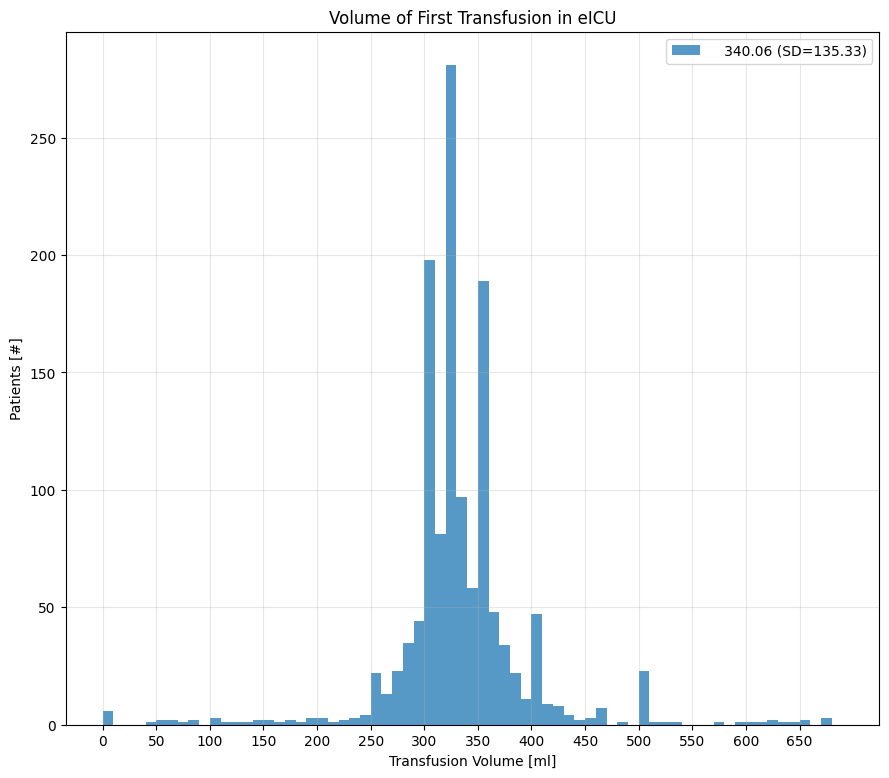

In [153]:
import numpy as np
import matplotlib.pyplot as plt

# Giovanni: this is invariant to WINDOW_SIZE and OFFSET

def labeled_plot(data:pd.Series,ax,label:str,f,**kwargs):
    mn=data.mean()
    sd=data.std()
    ulabel=f'{label}   {mn:.2f} (SD={sd:.2f})'
    return getattr(data.plot,f)(ax=ax,label=ulabel,**kwargs)

fig,ax=plt.subplots(figsize=(10.5,9))
_=labeled_plot(df.treatment_value,ax,'','hist',bins=np.arange(0,700,10),alpha=.75)
_=ax.set_xticks(np.arange(0,700,50))
_=ax.set_xlabel('Transfusion Volume [ml]')
_=ax.set_ylabel('Patients [#]')
_=ax.set_title('Volume of First Transfusion in eICU')
_=ax.grid(alpha=.3)
_=ax.legend()

<>:16: SyntaxWarning: invalid escape sequence '\D'
<>:16: SyntaxWarning: invalid escape sequence '\D'
/tmp/ipykernel_15285/102904041.py:16: SyntaxWarning: invalid escape sequence '\D'
  _=ax[1].set_xlabel('$\Delta$ HGB [g/dL]')


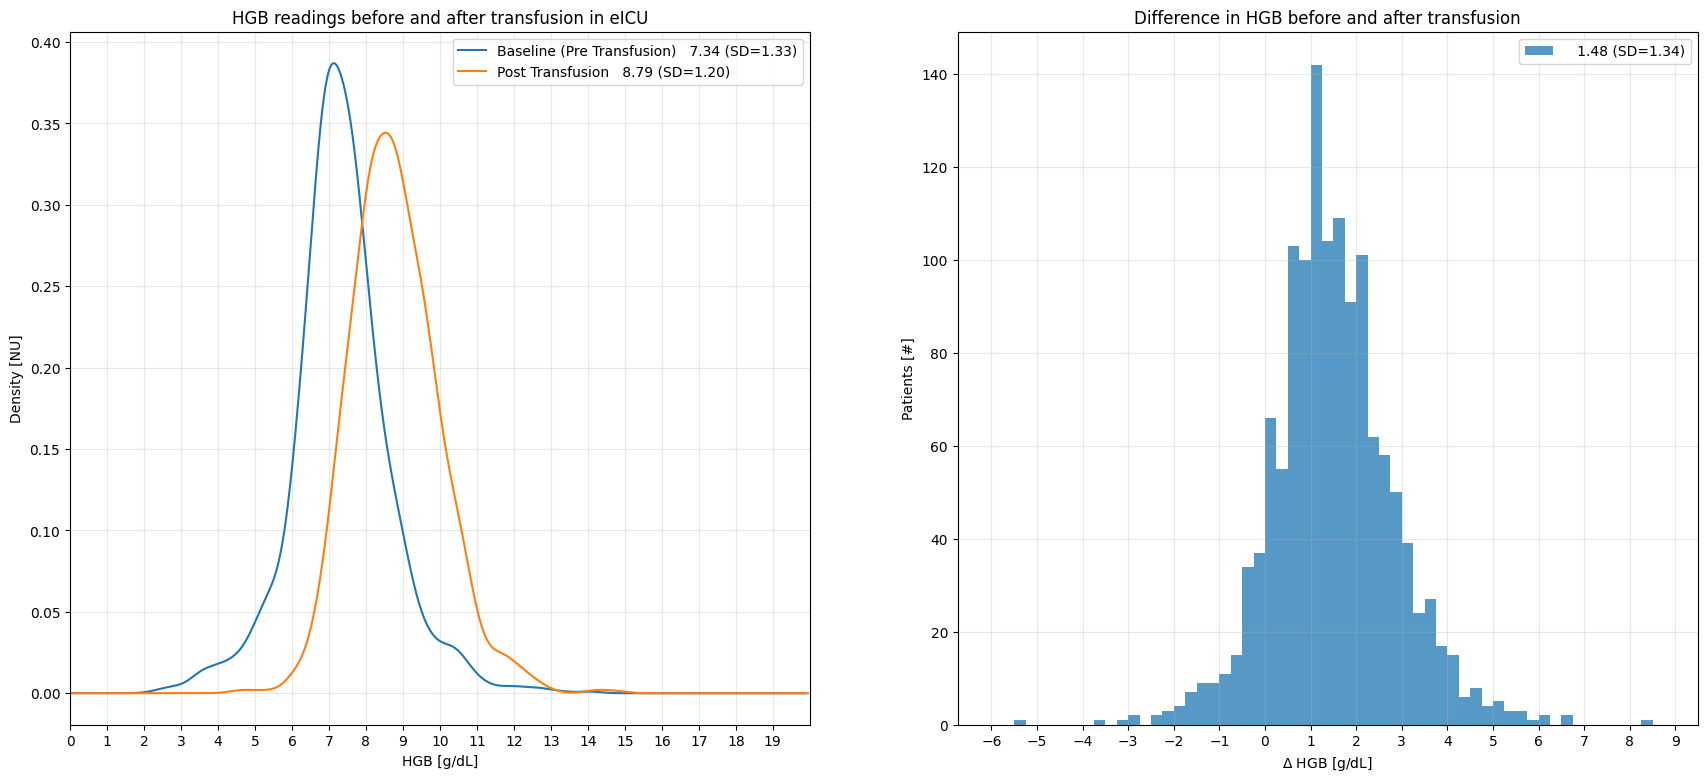

In [154]:
fig,ax=plt.subplots(1,2,figsize=(21,9))

_=labeled_plot(df.baseline,ax=ax[0],label='Baseline (Pre Transfusion)',f='kde')
_=labeled_plot(df.post_treatment,ax=ax[0],label='Post Transfusion',f='kde')

_=ax[0].legend()
_=ax[0].set_xlim([0,20])
_=ax[0].set_xticks(np.arange(0,20,1.))
_=ax[0].set_xlabel('HGB [g/dL]')
_=ax[0].set_ylabel('Density [NU]')
_=ax[0].set_title('HGB readings before and after transfusion in eICU')
_=ax[0].grid(alpha=.3)

_=labeled_plot(df.treatment_effect,ax=ax[1],label='',f='hist',bins=np.arange(-6,9,.25),alpha=.75)
_=ax[1].set_xticks(np.arange(-6,10,1.))
_=ax[1].set_xlabel('$\Delta$ HGB [g/dL]')
_=ax[1].set_ylabel('Patients [#]')
_=ax[1].set_title('Difference in HGB before and after transfusion')
_=ax[1].grid(alpha=.3)
_=ax[1].legend()

In [206]:
# Note for Hashem: I bet you can improve this by a lot (but keep interpretability)
from sklearn.linear_model import Ridge
from sklearn.model_selection import RepeatedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from crlearn.evaluation import crossvalidate_regression
from sklearn.metrics import r2_score,root_mean_squared_error

to_censor=['post_treatment','treatment_effect','icu_outcome','hosp_outcome']
outcome=['treatment_effect']
features=['baseline','age','gender','ethnicity','initial_weight','treatment_value','treatment_offset','nettotal','gi_bleeder']
categorical=['gender','ethnicity','gi_bleeder']
continuous=[val for val in features if val not in categorical]

X,y=df[features],df[outcome]

cnt_processor=Pipeline([('impute',SimpleImputer()),('scaling',StandardScaler())])
cat_processor=Pipeline([('impute',SimpleImputer(strategy='most_frequent')),('ohe',OneHotEncoder(drop='if_binary',sparse_output=False,min_frequency=20))]) 
processor=ColumnTransformer([
    ('categorical',cat_processor,categorical),
    ('continuous',cnt_processor,continuous),
])
model=Pipeline([('processor',processor),('regressor',Ridge(random_state=0))])
cv=RepeatedKFold(n_splits=10,n_repeats=10)

def tracing_func(model):
    coef=np.squeeze(model[-1].coef_)
    fcat=model[0]['categorical'][1].get_feature_names_out(categorical)
    return pd.Series(coef,index=[*fcat,*continuous])

In [207]:
trace=[]
scores=[]
scoring=[r2_score,root_mean_squared_error]
for train,test in cv.split(X,y):
    model=model.fit(X.iloc[train],y.iloc[train])

    y_pred=model.predict(X.iloc[test])
    scores.append([root_mean_squared_error(y.iloc[test],y_pred),r2_score(y.iloc[test],y_pred)])
    trace.append(tracing_func(model))

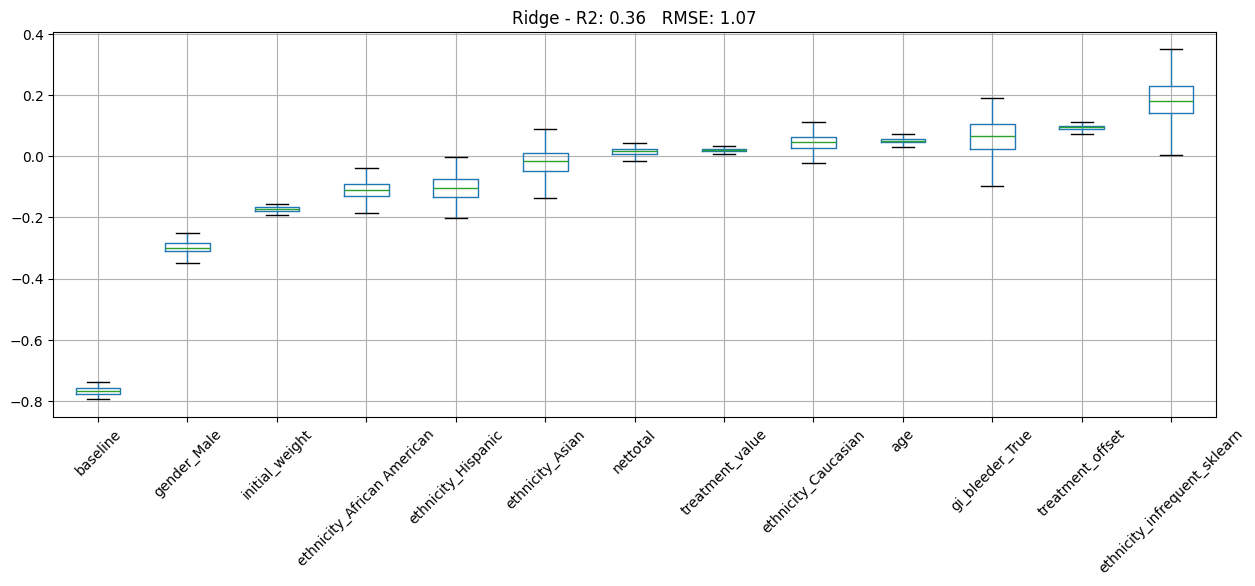

In [208]:
scores=pd.DataFrame(scores,columns=['rmse','r2'])
traces=pd.concat(trace,axis=1).T
traces=traces[traces.mean().sort_values().index]

fig,ax=plt.subplots(figsize=(15,5))
_=traces.boxplot(showfliers=False,rot=45,ax=ax)
_=ax.set_title(f'Ridge - R2: {scores.r2.mean():.2f}   RMSE: {scores.rmse.mean():.2f}')